In [1]:
from qsubgisom.qsubgisom import ansatz, observable, s4_ansatz
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP, GradientDescent
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.quantum_info import Operator
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import networkx as nx

## A simple demo for the special case of the graph isomorphism.

In [2]:
def checkboard(n):
    """
    Produce a matrix with the checkboard pattern.
    In the case n=4, the resulting 4x4 matrix corresponds to
    the adjacency matrix of a graph having 4 vertices interconnected
    to form a square.
    """
    c = np.arange(n//2)*2
    c = np.tile(c, len(c)), np.repeat(c + 1, len(c))
    m = np.zeros((n, n), dtype=int)
    m[c] = 1
    m[(c[1], c[0])] = 1
    return m

def rnd_perm_mat(n, *, seed=None):
    """
    Produce a nxn random permutation matrix.
    """
    rng = np.random.default_rng(seed=seed)
    m = np.eye(n, dtype=int)
    rng.shuffle(m)
    return m

In [3]:
seed = 102837648
algorithm_globals.random_seed = seed
rng = np.random.default_rng(seed=seed)
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed,
                     shots=1024)

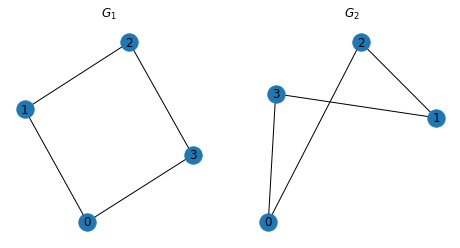

In [4]:
# Prepare the input adjacency matrices. The variable adj1 contains the adjacency matrix
# of the first input graph. The adj2 is a random permutation (p) of the adjacency matrix adj1.
adj1 = checkboard(4)
p = rnd_perm_mat(4, seed=1290313)
adj2 = p @ adj1 @ p.T

g1, g2 = map(nx.from_numpy_matrix, (adj1, adj2))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
nx.draw(g1, labels={k: k for k in range(len(adj1))}, ax=axs[0])
axs[0].set_title('$G_1$')
nx.draw(g2, labels={k: k for k in range(len(adj2))}, ax=axs[1])
axs[1].set_title('$G_2$')
plt.show()

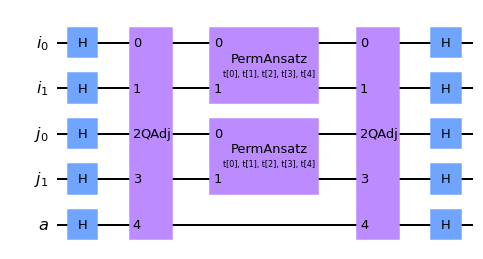

In [5]:
qc, params = ansatz(adj1, adj2)
qc.draw('mpl')

In [6]:
max_trials = 4
optim = SLSQP(maxiter=1000)

def trial():
    initial_point = (rng.uniform(size=len(qc.parameters)) - 1/2) * np.pi
    vqe = VQE(qc, quantum_instance=qi, initial_point=initial_point,
            optimizer=optim)
    obj = vqe.compute_minimum_eigenvalue(observable(qc.num_qubits))
    return obj.optimal_value, obj

results = [trial() for _ in tqdm(range(max_trials))]
results = sorted(results, key=lambda obj: obj[0])
result = results[0][1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


In [7]:
# Parameterize the permutation ansatz with the parameters obtained by means of VQE.
qc1 = s4_ansatz('circular', qreg=(qc.num_qubits - 1)//2, params=params)[0]
qc1 = qc1.bind_parameters(result.optimal_parameters)
# qc1.draw('mpl')

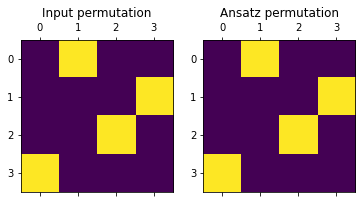

In [8]:
# Extract the undelying matrix from the permutation ansatz
p1 = np.abs(Operator(qc1).data)

# Round the permutation implmented by the ansatz
p2 = np.eye(len(p1))
p2 = p2[np.argmax(p1, axis=1)]

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].matshow(p, vmin=0, vmax=1)
axs[0].set_title('Input permutation')
axs[1].matshow(p2, vmin=0, vmax=1)
axs[1].set_title('Ansatz permutation')
plt.show()

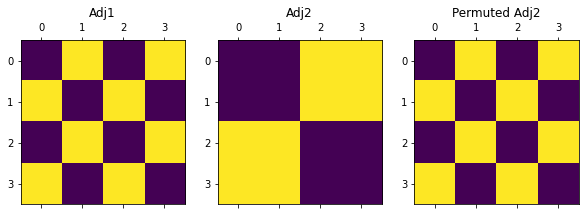

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].matshow(adj1)
axs[0].set_title('Adj1')
axs[1].matshow(adj2)
axs[1].set_title('Adj2')
axs[2].matshow(p2.T @ adj2 @ p2)
axs[2].set_title('Permuted Adj2')
plt.show()